In [22]:
import scipy.stats
import imageio
import math
import numpy as np
import scipy as sp
import sys
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [23]:
def psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR


In [24]:
def refine_wideband_attentuation(uw,above_water, depths, restarts=25):

    min_depth = np.percentile(depths, 0.5, axis=None, out=None) 
    max_depth = np.percentile(depths, 99.5, axis=None, out=None) 
    pts_to_consider = np.where(np.logical_and(depths>=min_depth,depths<=max_depth))
    
    print(uw.shape,above_water.shape)

    depth_values = depths[pts_to_consider]
    above_water_pts = above_water[pts_to_consider]
    uw_pts = uw[pts_to_consider]
    
    coefs = None
    best_loss = np.inf
    def calc_image(above_water_points,beta_D,Bc,beta_B):
        return above_water_points*np.exp(-beta_D*depth_values) + Bc*(1-np.exp(-beta_B*depth_values))

    def loss(above_water_points,beta_D,Bc,beta_B):
        return np.mean(np.abs(uw_pts-calc_image(above_water_points,beta_D,Bc,beta_B)))

    for _ in range(restarts):
        try:
            optp, pcov = sp.optimize.curve_fit(
                f=calc_image,
                xdata=above_water_pts,
                ydata=uw_pts,
                p0=np.abs(np.random.random(3)) * np.array([5., 1.,2.5]),
                bounds=([0, 0, 0], [10, 1, 5]))
            L = loss(above_water_pts,*optp)
            if L < best_loss:
                best_loss = L
                coefs = optp
        except RuntimeError as re:
            print(re, file=sys.stderr)
    # Uncomment to see the regression
    # plt.clf()
    # plt.scatter(depths[locs], estimation[locs])
    # plt.plot(np.sort(depths[locs]), calculate_beta_D(np.sort(depths[locs]), *coefs))
    # plt.show()

    print(f'Found best loss {best_loss}', flush=True)
    
    return coefs

In [25]:
above_water = imageio.imread("results/output_wo_back_3_WB.jpg")/255
under_water_og = imageio.imread("results/output_postprocess_3.jpg")/255
under_water_og = cv2.resize(under_water_og, (above_water.shape[1],above_water.shape[0]), interpolation = cv2.INTER_AREA)

In [26]:
def load_image_and_depth_map(depths_fname,dim):
    
    depths = np.array(Image.open(depths_fname))
    depth_resized = cv2.resize(depths, (dim), interpolation = cv2.INTER_AREA)
    return depth_resized

In [27]:
depths_fname = "../SeaThru_TEST/depthMaps/depthT_S03371.tif"
depth_resized = load_image_and_depth_map(depths_fname,(under_water_og.shape[1],under_water_og.shape[0]))

In [28]:
above_water.shape

(683, 1024, 3)

In [29]:
uw_red_channel = under_water_og[:,:,0]
above_water_red = above_water[:,:,0]
coeffs_R = refine_wideband_attentuation(uw_red_channel,above_water_red, depth_resized)

uw_red_channel = under_water_og[:,:,1]
above_water_red = above_water[:,:,1]
coeffs_G = refine_wideband_attentuation(uw_red_channel,above_water_red, depth_resized)

uw_red_channel = under_water_og[:,:,2]
above_water_red = above_water[:,:,2]
coeffs_B = refine_wideband_attentuation(uw_red_channel,above_water_red, depth_resized)

(683, 1024) (683, 1024)
Found best loss 0.05123069044941635
(683, 1024) (683, 1024)
Found best loss 0.07133958969031542
(683, 1024) (683, 1024)
Found best loss 0.06377591507222426


In [30]:
beta_d = np.array([coeffs_R[0],coeffs_G[0],coeffs_B[0]])
B_inf = np.array([coeffs_R[1],coeffs_G[1],coeffs_B[1]])
beta_B = np.array([coeffs_R[2],coeffs_G[2],coeffs_B[2]])

In [31]:
beta_d,B_inf,beta_B

(array([2.04199786e+00, 7.17391654e-11, 2.45694210e-02]),
 array([0.59820729, 0.77813652, 0.55382318]),
 array([0.02708864, 0.51158993, 0.76827653]))

In [32]:
under_water = above_water*np.exp(-beta_d*depth_resized[:,:,np.newaxis]) + B_inf*(1-np.exp(-beta_B*depth_resized[:,:,np.newaxis]))

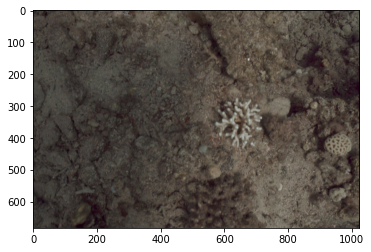

In [33]:
plt.imshow(above_water)

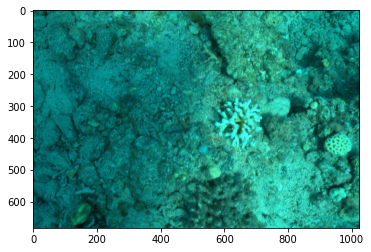

In [36]:
plt.imshow(under_water_og)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


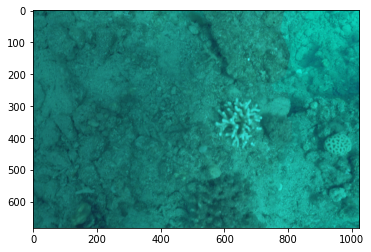

In [34]:
plt.imshow(under_water)

In [35]:
psnr(np.array(under_water*255,dtype=np.uint8), np.array(above_water*255,dtype=np.uint8))

27.40684054237142